# Expected Goals in Professional Soccer

In [1]:
#Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn.metrics as metrics
import math

In [2]:
# Load the dataset from a CSV file into a pandas DataFrame
df = pd.read_csv("data/GoalData.csv")
print(df.head)

<bound method NDFrame.head of      Wk  Day        Date           Time           Home  HomexG Score  AwayxG  \
0     1  Fri  2023-08-11  20:00 (14:00)        Burnley     0.3   0–3     1.9   
1     1  Sat  2023-08-12  12:30 (06:30)        Arsenal     0.8   2–1     1.2   
2     1  Sat  2023-08-12  15:00 (09:00)        Everton     2.7   0–1     1.5   
3     1  Sat  2023-08-12  15:00 (09:00)  Sheffield Utd     0.5   0–1     1.9   
4     1  Sat  2023-08-12  15:00 (09:00)       Brighton     4.0   4–1     1.5   
..   ..  ...         ...            ...            ...     ...   ...     ...   
273  28  Sun  2024-03-10  13:00 (08:00)    Aston Villa     0.8   0–4     1.5   
274  28  Sun  2024-03-10  14:00 (09:00)       West Ham     2.1   2–2     0.7   
275  28  Sun  2024-03-10  14:00 (09:00)       Brighton     0.4   1–0     0.7   
276  28  Sun  2024-03-10  15:45 (10:45)      Liverpool     2.7   1–1     1.6   
277  28  Mon  2024-03-11  20:00 (15:00)        Chelsea     1.6   3–2     0.7   

         

## Data Pre-Processing

In [3]:
# Function to extract the home team's goal count from the 'Score' field
def gather_home_goals(value):
    if value is not None:
        return int(value[0])  
    pass  

# Function to extract the away team's goal count from the 'Score' field
def gather_away_goals(value):
    if value is not None:
        return int(value[2])  
    
# Function to determine the match winner based on the score
def gather_winner(value):
    if value is not None:
        if int(value[0]) > int(value[2]):
            return 'H'  
        elif int(value[2]) > int(value[0]):
            return 'A'  
        return 'T'  

# Function to determine if the home team won (binary outcome)
def gather_home_winner(value):
    if value is not None:
        if value == 'H':
            return 1  
        return 0  
    
# Function to determine if the away team won (binary outcome)
def gather_away_winner(value):
    if value is not None:
        if value == 'A':
            return 1  
        return 0 

# Apply functions to extract home and away goal counts from the 'Score' field
df['HomeG'] = df['Score'].apply(lambda x: gather_home_goals(x))
df['AwayG'] = df['Score'].apply(lambda x: gather_away_goals(x))

# Calculate the goal difference between actual goals and expected goals for home and away teams
df['DiffHxG'] = df['HomeG'] - df['HomexG']
df['DiffAxG'] = df['AwayG'] - df['AwayxG']

# Determine the match result (winner)
df['Result'] = df['Score'].apply(lambda x: gather_winner(x))

# Create dataframes for home and away teams with relevant columns
dfH = df[['HomexG', 'DiffHxG', 'Result']].copy()
dfA = df[['AwayxG', 'DiffAxG', 'Result']].copy()

# Rename columns in the dataframes for clarity and apply the functions to determine binary results
dfH.rename(columns={'HomexG': 'xG', 'DiffHxG': 'DiffxG'}, inplace=True)
dfH['Result'] = dfH['Result'].apply(lambda x: gather_home_winner(x))

dfA.rename(columns={'AwayxG': 'xG', 'DiffAxG': 'DiffxG'}, inplace=True)
dfA['Result'] = dfA['Result'].apply(lambda x: gather_away_winner(x))

# Ensure that the dataframes only contain the desired columns after renaming
dfH = dfH[['xG', 'DiffxG', 'Result']].copy()
dfA = dfA[['xG', 'DiffxG', 'Result']].copy()

# Concatenate the dataframes for home and away into a single dataframe
df2 = pd.concat([dfH, dfA])

# Display the final dataframe after processing and transformations
print(df2)

      xG  DiffxG  Result
0    0.3    -0.3       0
1    0.8     1.2       1
2    2.7    -2.7       0
3    0.5    -0.5       0
4    4.0     0.0       1
..   ...     ...     ...
273  1.5     2.5       1
274  0.7     1.3       0
275  0.7    -0.7       0
276  1.6    -0.6       0
277  0.7     1.3       0

[556 rows x 3 columns]


## KNN Modeling

      xG  DiffxG
0    0.3    -0.3
1    0.8     1.2
2    2.7    -2.7
3    0.5    -0.5
4    4.0     0.0
..   ...     ...
273  1.5     2.5
274  0.7     1.3
275  0.7    -0.7
276  1.6    -0.6
277  0.7     1.3

[556 rows x 2 columns]
0      0
1      1
2      0
3      0
4      1
      ..
273    1
274    0
275    0
276    0
277    0
Name: Result, Length: 556, dtype: int64
Model accuracy: 0.81


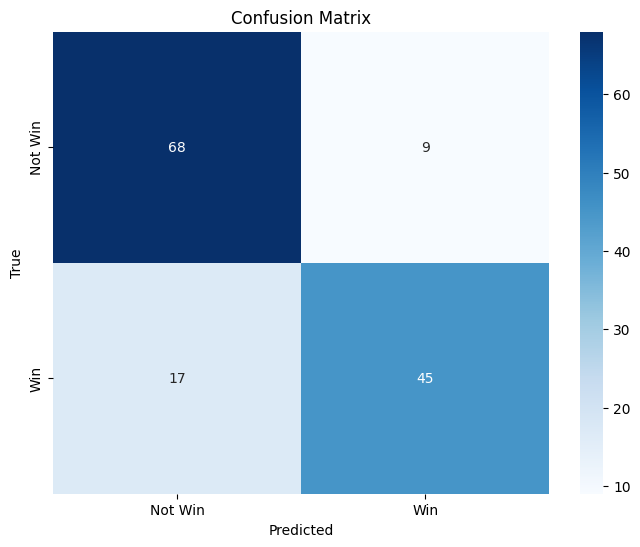

In [4]:
# Separate features (X) and labels (y) from the dataframe
X = df2[['xG', 'DiffxG']] 
y = df2['Result']  
print(X) 
print(y)  


# Split the data into training and test sets (75% training, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define the number of neighbors for KNN
N_Value = 5

# Create a KNN classifier with the specified number of neighbors
knn = KNeighborsClassifier(n_neighbors=N_Value)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}") 

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Win', 'Win'], yticklabels=['Not Win', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Test Predictions

15
14


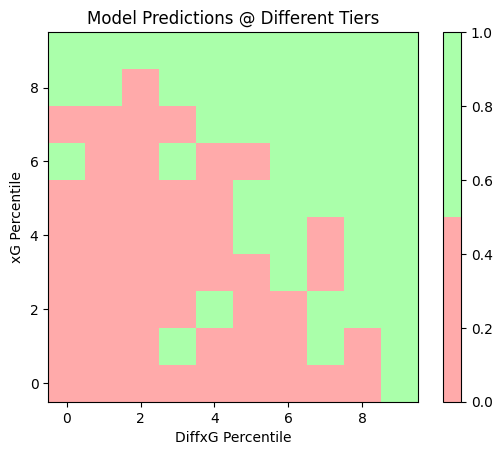

C:\Users\LANDE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


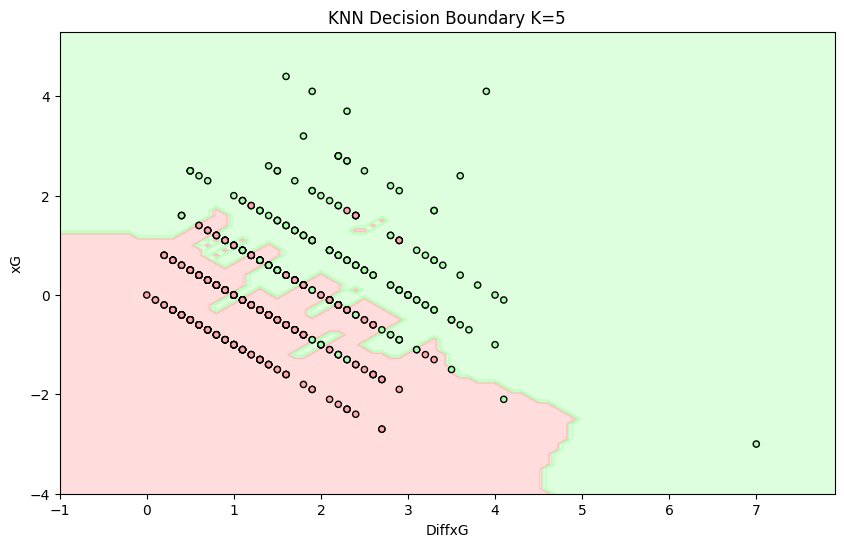

In [5]:
# Define percentiles of interest for analysis
percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]

# Calculate quantiles for 'xG' and 'DiffxG' from the dataframe 'df2'
xG_percentiles = df2['xG'].quantile(percentiles)
DiffxG_percentiles = df2['DiffxG'].quantile(percentiles)

predicted_results = []

# Loop over each 'xG' percentile
for xG_percentile in xG_percentiles:
    xG_percentile_prediction = []
    for DiffxG_percentile in DiffxG_percentiles:
        test_data_df = pd.DataFrame({
            'xG': [xG_percentile],  
            'DiffxG': [DiffxG_percentile]  
        })

        predicted_result = knn.predict(test_data_df)
        xG_percentile_prediction.append(predicted_result[0])
    predicted_results.append(xG_percentile_prediction)

DiffxG_win_count = 0
xG_win_count = 0

# Count wins where result is 1 for first five 'DiffxG' percentiles
for i in range(5):
    for result in predicted_results[i]:
        if result == 1:
            DiffxG_win_count += 1

print(DiffxG_win_count)

# Count wins where result is 1 for each 'xG' percentile in the first five columns
for result_set in predicted_results:
    for i in range(5):
        if result_set[i] == 1:
            xG_win_count += 1

print(xG_win_count)


# Define a color map for the contour plot (Red and Green for Win and Loss)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])  


plt.imshow(predicted_results, cmap=cmap_light, interpolation='nearest')
plt.gca().invert_yaxis()
plt.xlabel('DiffxG Percentile')
plt.ylabel('xG Percentile')
plt.title('Model Predictions @ Different Tiers')
plt.colorbar()
plt.show()

# Define plot boundaries based on the minimum and maximum values of the features
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1 
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1  

# Generate a grid of points to plot the decision boundary
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the labels for all points in the grid to visualize decision boundaries
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the data points
plt.figure(figsize=(10, 6))  
plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)  
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_light, s=20, edgecolors='k') 
plt.xlabel('DiffxG') 
plt.ylabel('xG')  
plt.title(f'KNN Decision Boundary K={N_Value}') 
plt.show() 

## Prediction Forecasting 

In [6]:
# get train tests split 
df = pd.read_csv("data/GoalData.csv")
train = df
test = df[(3*len(df)//4):len(df)]

In [7]:
# Clean and process the data
def clean(data):
    cols = ['Wk', 'Home', 'HomexG', 'Score', 'AwayxG', 'Away']
    data = data[cols].copy()
    data['AwayG'] = data['Score'].apply(lambda x: gather_away_goals(x))
    data['HomeG'] = data['Score'].apply(lambda x: gather_home_goals(x))
    data['AwayxGDiff'] = data['AwayG'] - data['AwayxG']
    data['HomexGDiff'] = data['HomeG'] - data['HomexG']
    data['Result'] = data['Score'].apply(lambda x: gather_winner(x))
    data['xGDiff'] = abs(data['AwayxG'] - data['HomexG'])
    data['diffxGDiff'] = abs(data['AwayxGDiff']-data['HomexGDiff'])
    data = data.drop(columns=['Score', 'AwayG', 'HomeG'])
    return data

clean_train = clean(train)
clean_test = clean(test)

### Season Long Forecasting

In [8]:
teams = ['Arsenal', 'Manchester City', 'Liverpool', 'Aston Villa', 'Tottenham', 'Newcastle Utd', 'Chelsea', 'Manchester Utd', 'West Ham', 'Bournemouth', 'Brighton', 'Wolves', 'Fulham', 'Crystal Palace', 'Everton', 'Brentford', "Nott'ham Forest", 'Luton Town', 'Burnley', 'Sheffield Utd']

# gather the average home xG and awayxG for each team
def getRollingAverage(week, numWeeks):
    xgResults = {}
    average = clean_train[(clean_train['Wk'] > (week - numWeeks)) & (clean_train['Wk'] <= week)]
    for team in teams:
        avgHomeXg = average[average['Home'] == team]['HomexG'].mean()
        avgAwayXg = average[average['Away'] == team]['AwayxG'].mean()
        xgResults[team] = (avgHomeXg, avgAwayXg)
    avgTieXG = average[average['Result']=='T']['xGDiff'].mean()
    avgTieXG /= math.sqrt(numWeeks)
    return xgResults, avgTieXG

# this is our population deviation, normalize it for sample. With 21 games, we assume each team plays 10 home and 11 away
# leaving us with 10 as our minimum
xgResults, avgTieXG = getRollingAverage(21, 21)
print(xgResults, avgTieXG)


{'Arsenal': (2.1999999999999997, 1.55), 'Manchester City': (1.7200000000000002, 2.2636363636363637), 'Liverpool': (2.8, 1.6090909090909091), 'Aston Villa': (2.17, 1.409090909090909), 'Tottenham': (2.01, 1.4727272727272727), 'Newcastle Utd': (2.290909090909091, 1.53), 'Chelsea': (2.118181818181818, 1.8399999999999999), 'Manchester Utd': (1.7181818181818185, 1.11), 'West Ham': (1.2599999999999998, 1.5636363636363635), 'Bournemouth': (1.2900000000000003, 1.56), 'Brighton': (2.018181818181818, 1.35), 'Wolves': (1.3000000000000003, 1.3636363636363635), 'Fulham': (1.6, 0.8454545454545456), 'Crystal Palace': (1.2, 1.1818181818181819), 'Everton': (1.7545454545454546, 1.1700000000000002), 'Brentford': (1.7999999999999998, 1.4400000000000002), "Nott'ham Forest": (1.15, 1.2363636363636363), 'Luton Town': (1.1800000000000002, 0.82), 'Burnley': (0.990909090909091, 0.7500000000000001), 'Sheffield Utd': (1.2000000000000002, 0.5700000000000001)} 0.14963512473325194


In [9]:
def predict_result(homeXg, awayXg, tieBarrier):
    if(abs(homeXg-awayXg)<tieBarrier):
        return 'T'
    elif(homeXg-awayXg)>0:
        return 'H'
    return 'A'

predxG = []
for index,row in clean_test.iterrows():
    predxG.append(predict_result(xgResults[row['Home']][0], xgResults[row['Away']][1], avgTieXG))
actualxG = clean_test['Result'].to_list()

In [10]:
accuracy = metrics.accuracy_score(actualxG, predxG)
print("Accuracy of season long xG to predict result:", accuracy)

Accuracy of season long xG to predict result: 0.6


In [11]:
teams = ['Arsenal', 'Manchester City', 'Liverpool', 'Aston Villa', 'Tottenham', 'Newcastle Utd', 'Chelsea', 'Manchester Utd', 'West Ham', 'Bournemouth', 'Brighton', 'Wolves', 'Fulham', 'Crystal Palace', 'Everton', 'Brentford', "Nott'ham Forest", 'Luton Town', 'Burnley', 'Sheffield Utd']

# gather the average home xG and awayxG for each team
def getRollingAverageDiff(week, numWeeks):
    xgResults = {}
    average = clean_train[clean_train['Wk']>(week-numWeeks)]
    average = average[average['Wk']<=week]
    for team in teams:
        avgHomeXg = average[average['Home'] == team]['HomexGDiff'].mean()
        avgAwayXg = average[average['Away'] == team]['AwayxGDiff'].mean()
        xgResults[team] = (avgHomeXg, avgAwayXg)
    avgTieXG = average[average['Result']=='T']['diffxGDiff'].mean()
    avgTieXG /= math.sqrt(numWeeks)
    return xgResults, avgTieXG

diffXgResults, avgTieDiffXG = getRollingAverageDiff(21, 21)


print(diffXgResults)
print(avgTieDiffXG)

{'Arsenal': (0.2545454545454545, -0.050000000000000024), 'Manchester City': (0.7799999999999998, -0.0818181818181818), 'Liverpool': (-0.2, 0.30000000000000004), 'Aston Villa': (0.73, -0.13636363636363635), 'Tottenham': (-0.009999999999999964, 0.7090909090909091), 'Newcastle Utd': (-0.018181818181818136, 0.06999999999999992), 'Chelsea': (-0.4818181818181818, -0.1399999999999999), 'Manchester Utd': (-0.3545454545454545, -0.21000000000000005), 'West Ham': (0.43999999999999995, 0.07272727272727271), 'Bournemouth': (-0.19, 0.13999999999999996), 'Brighton': (-0.0181818181818182, 0.25), 'Wolves': (0.3, -0.09090909090909088), 'Fulham': (0.3, -0.02727272727272728), 'Crystal Palace': (-0.1, -0.18181818181818182), 'Everton': (-0.7545454545454544, 0.12999999999999998), 'Brentford': (0.018181818181818136, -0.54), "Nott'ham Forest": (0.25000000000000006, -0.14545454545454545), 'Luton Town': (0.12000000000000002, 0.28), 'Burnley': (0.00909090909090912, 0.25), 'Sheffield Utd': (-0.10909090909090907, -

In [12]:
#Season Long
predDiffxG = []
for index,row in clean_test.iterrows():
    predDiffxG.append(predict_result(diffXgResults[row['Home']][0], diffXgResults[row['Away']][1], avgTieDiffXG))
actualDiffxG = clean_test['Result'].to_list()
accuracy = metrics.accuracy_score(actualDiffxG, predDiffxG)
print("Accuracy of season long diffXG to predict result:", accuracy)

Accuracy of season long diffXG to predict result: 0.35714285714285715


### Rolling Average Forecasting

In [13]:
#predict week by week
predRollingxG = []
actualRollingxG = []
for j in range(1, 21):
    for i in range(0,7):
        xgResults, avgTieXG = getRollingAverage(21 + i, j)
        week = 21+i
        thisWeek = clean_train[clean_train['Wk'] == week]
        for index,row in thisWeek.iterrows():
            predRollingxG.append(predict_result(xgResults[row['Home']][0], xgResults[row['Away']][1], avgTieXG))
            actualRollingxG.append(row['Result'])
    accuracy = metrics.accuracy_score(actualRollingxG, predRollingxG)
    print("Accuracy of rolling XG to predict result:", accuracy, j)

Accuracy of rolling XG to predict result: 0.5942028985507246 1
Accuracy of rolling XG to predict result: 0.6231884057971014 2
Accuracy of rolling XG to predict result: 0.5893719806763285 3
Accuracy of rolling XG to predict result: 0.572463768115942 4
Accuracy of rolling XG to predict result: 0.5652173913043478 5
Accuracy of rolling XG to predict result: 0.5603864734299517 6
Accuracy of rolling XG to predict result: 0.5527950310559007 7
Accuracy of rolling XG to predict result: 0.5471014492753623 8
Accuracy of rolling XG to predict result: 0.537842190016103 9
Accuracy of rolling XG to predict result: 0.5304347826086957 10
Accuracy of rolling XG to predict result: 0.5230566534914362 11
Accuracy of rolling XG to predict result: 0.5181159420289855 12
Accuracy of rolling XG to predict result: 0.5161649944258639 13
Accuracy of rolling XG to predict result: 0.5124223602484472 14
Accuracy of rolling XG to predict result: 0.5101449275362319 15
Accuracy of rolling XG to predict result: 0.5072463

In [14]:
#predict week by week
predRollingDiffxG = []
actualRollingDiffxG = []
for j in range(1, 21):
    for i in range(0,7):
        xgResults, avgTieXG = getRollingAverageDiff(21 + i, j)
        week = 21+i
        thisWeek = clean_train[clean_train['Wk'] == week]
        for index,row in thisWeek.iterrows():
            predRollingDiffxG.append(predict_result(xgResults[row['Home']][0], xgResults[row['Away']][1], avgTieXG))
            actualRollingDiffxG.append(row['Result'])
    accuracy = metrics.accuracy_score(actualRollingDiffxG, predRollingDiffxG)
    print("Accuracy of rolling diffXG to predict result:", accuracy, j)

Accuracy of rolling diffXG to predict result: 0.6521739130434783 1
Accuracy of rolling diffXG to predict result: 0.6666666666666666 2
Accuracy of rolling diffXG to predict result: 0.6280193236714976 3
Accuracy of rolling diffXG to predict result: 0.6123188405797102 4
Accuracy of rolling diffXG to predict result: 0.5971014492753624 5
Accuracy of rolling diffXG to predict result: 0.5893719806763285 6
Accuracy of rolling diffXG to predict result: 0.5817805383022774 7
Accuracy of rolling diffXG to predict result: 0.5688405797101449 8
Accuracy of rolling diffXG to predict result: 0.5523349436392915 9
Accuracy of rolling diffXG to predict result: 0.5420289855072464 10
Accuracy of rolling diffXG to predict result: 0.538866930171278 11
Accuracy of rolling diffXG to predict result: 0.5362318840579711 12
Accuracy of rolling diffXG to predict result: 0.5328874024526199 13
Accuracy of rolling diffXG to predict result: 0.5289855072463768 14
Accuracy of rolling diffXG to predict result: 0.5246376811